# Derive models of spacecraft with star tracker

Do all imports.

In [2]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [3]:
wheels = [
    {'alpha': 1 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 3 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 5 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 0, 'delta': - np.pi / 2},
]

stars = [
    {'alpha':  0.20, 'delta':  0.00},
    {'alpha':  0.10, 'delta':  0.00},
    {'alpha':  -0.20, 'delta':  0.00},
    {'alpha':  0.00, 'delta':  0.20},
    {'alpha':  0.00, 'delta':  -0.20},
]

m, J = design.create_spacecraft(wheels)

# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

alpha, delta = sym.symbols('alpha, delta')

# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

## Derive A and B

In [4]:
from scipy.linalg import solve_continuous_are
import numpy.linalg as la

def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

def findKL(Qi,Ri,Q0i,R0i,stars):
    m = (psi, theta, phi, w_x, w_y, w_z)
    n = (tau_1, tau_2, tau_3, tau_4)
    mn = (psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4)

    xd = f

    An = sym.lambdify(mn, xd.jacobian(m))
    Bn = sym.lambdify(mn, xd.jacobian(n))

    # the satilite must be stationary and not be 
    # applying any torque to stop the wheels from going to fast
    A = An(0,0,0,0,0,0,0,0,0,0)
    B = Bn(0,0,0,0,0,0,0,0,0,0)

    Q = Qi
    R = Ri

    P = solve_continuous_are(A,B,Q,R)
    K = la.inv(R) @ B.T @ P

    g_all = []
    for s in stars:
        g_i = g.subs({alpha: s['alpha'], delta: s['delta']})
        g_all.append(g_i)
    h = sym.Matrix.vstack(*g_all)  # size 2N x 1

    # Derivative w.r.t orientation part of state
    x_sensor = sym.Matrix([psi, theta, phi])
    C_h = h.jacobian(x_sensor)

    # Evaluate at equilibrium (psi=theta=phi=0)
    C_eq = C_h.subs({psi: 0, theta: 0, phi: 0})

    # Convert to numpy function
    C_func = sym.lambdify((), C_eq)
    C_num = np.array(C_func(), dtype=np.float64)

    # Pad with zeros to make it 2N x 6 (full state)
    C = np.hstack((C_num, np.zeros((C_num.shape[0], 3))))

    # Define weight matrices for LQR
    Q0 = Q0i
    R0 = R0i

    L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T

    return K,L

In [5]:
class Controller:
    def __init__(self, A, B, C, K, L, stars, dt = 0.04):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.dt = dt
        self.xhat = np.zeros(6)
        self.star_e = stars
        self.log = True

        # For logging
        self.t_log = []
        self.xhat_log = []

    
    def reset(self):
        self.xhat = np.zeros(6)
        self.t_log = []
        self.xhat_log = []
    
    def run(self, t, star_measurements):
        u = -self.K @ self.xhat

        y = star_measurements - self.star_e

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        self.t_log.append(t)
        self.xhat_log.append(self.xhat.copy())

        torque_1, torque_2, torque_3, torque_4 = u
        
        return torque_1, torque_2, torque_3, torque_4
    
    def get_logs(self):
        return np.array(self.t_log), np.array(self.xhat_log)


In [6]:
import ae353_spacecraft_simulate

simulator = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1, #Test Recovory
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=20        # <-- how long it takes for the space-cat to dock with the spacecraft
)

In [7]:
def compute_rotation_score(true_rot, est_rot):
    # Reorder est_rot from [psi, theta, phi] to [phi, theta, psi]
    est_rot_reordered = est_rot[:, [2, 1, 0]]
    mse = np.mean((true_rot - est_rot_reordered)**2)
    return mse

In [8]:
A = [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
B = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.018530635807362836, 0.037061271614725715, -0.018530635807362836, -2.62041779934909e-18], [-0.032096002714907576, -4.538696765530462e-18, 0.032096002714907576, 0.0], [-0.0249042741960589, -0.0249042741960589, -0.0249042741960589, 0.0498085483921178]]
C = [[-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.532113843210265, 0.0, 0.0, 0.0], [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.263378514224308, 0.0, 0.0, 0.0], [-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, 0.532113843210265, 0.0, 0.0, 0.0], [-2.625, 0.0, 0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0], [-2.625, 0.0, -0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0]]

A = np.array(A)
B = np.array(B)
C = np.array(C)

stars_e = [0.5321138432102653, 0.0, 0.2633785142243077, 0.0, -0.5321138432102653, 0.0, 0.0, 0.5321138432102653, 0.0, -0.5321138432102653]



In [10]:
# Starting LQR guesses
Qm, Rm, Q0m, R0m = 1,1,1,1

Qd = np.diag((50,50,50,1,1,1)).astype(float)
Rd = np.diag((1,1,1,1)).astype(float)
Q0d = np.eye(10).astype(float)
R0d = np.eye(6).astype(float)

best_score = np.inf

Q = Qd*Qm
R = Rd*Rm
Q0 = Q0d*Q0m
R0 = R0d*R0m

best_params = (Q, R, Q0, R0)

n = 8
values = np.logspace(-4, 4, n)

print("Total sims:", n**4)
iters = 1

for Qm in values:
    for Rm in values:
        for Q0m in values:
            for R0m in values:
                Q = Qd*Qm
                R = Rd*Rm
                Q0 = Q0d*Q0m
                R0 = R0d*R0m

                K,L = findKL(Q,R,Q0,R0,stars)
                controller = Controller(A,B,C,K,L,stars_e)
                controller.reset()

                simulator.reset(
                initial_conditions={
                    'psi': 0.,
                    'theta': 0.,
                    'phi': 0.,
                    'w_x': 0.1, #Test Recovory
                    'w_y': 0.,
                    'w_z': 0.,
                }, scope_noise=0.1, space_debris=False, docking_time=60)

                data = simulator.run(controller,max_time=20.0,data_filename=None,video_filename=None,print_debug=False)

                true_rot = np.vstack([data['phi'], data['theta'], data['psi']]).T
                t_est, xhat_log = controller.get_logs()

                
                iters += 1
                
                if t_est.size > 0 and t_est[-1] > 19.9:
                    est_rot = xhat_log[:, 0:3]
                    min_len = min(len(true_rot), len(est_rot))
                    score = compute_rotation_score(true_rot[:min_len], est_rot[:min_len])
                    print(f"Iteration {iters}, Score: {score}")
                    if score < best_score:
                        best_score = score
                        best_params = (Qm,Rm,Q0m,R0m)


Total sims: 4096
Iteration 2, Score: 0.00018251722127631467
Iteration 3, Score: 0.00020575246279040858
Iteration 4, Score: 0.0024557136719995285
Iteration 5, Score: 0.02124746188609943
Iteration 6, Score: 0.09452966517804597
Iteration 7, Score: 0.21030397719301436
Iteration 8, Score: 0.3066225856290134
Iteration 9, Score: 0.3690022374092008
Iteration 10, Score: 0.000574941646566967
Iteration 11, Score: 0.0001606195668661162
Iteration 12, Score: 0.0003208366502685861
Iteration 13, Score: 0.002657140112351919
Iteration 14, Score: 0.019224069323074845
Iteration 15, Score: 0.0915594827378129
Iteration 16, Score: 0.20904159201232975
Iteration 17, Score: 0.30686787344225613
Iteration 18, Score: inf


C:\Users\jelly\AppData\Local\Temp\ipykernel_9280\960432056.py:4: RuntimeWarning: overflow encountered in square
  mse = np.mean((true_rot - est_rot_reordered)**2)


Iteration 19, Score: 0.0005952882316585099
Iteration 20, Score: 0.00016873813261012742
Iteration 21, Score: 0.000330877299007112
Iteration 22, Score: 0.002743517494538915
Iteration 23, Score: 0.01855713244572011
Iteration 24, Score: 0.09593654216817177
Iteration 25, Score: 0.20797474646430125
STOPED DUE TO STAR OUT OF VIEW


C:\Users\jelly\AppData\Local\Temp\ipykernel_9280\1896352973.py:31: RuntimeWarning: overflow encountered in matmul
  self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
C:\Users\jelly\AppData\Local\Temp\ipykernel_9280\1896352973.py:31: RuntimeWarning: invalid value encountered in matmul
  self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)


Iteration 27, Score: inf
Iteration 28, Score: 0.0004688933015323045
Iteration 29, Score: 0.00035805754996819653
Iteration 30, Score: 0.0006266722377062474
Iteration 31, Score: 0.002456845456904487
Iteration 32, Score: 0.020057383663320178
Iteration 33, Score: 0.09166228596352775
STOPED DUE TO STAR OUT OF VIEW


C:\Users\jelly\AppData\Local\Temp\ipykernel_9280\1896352973.py:26: RuntimeWarning: invalid value encountered in matmul
  u = -self.K @ self.xhat


STOPED DUE TO STAR OUT OF VIEW
Iteration 36, Score: inf
Iteration 37, Score: 0.0005751348134999943
Iteration 38, Score: 0.0001654150970795084
Iteration 39, Score: 0.0002900670748071321
Iteration 40, Score: 0.0031970704089796104
Iteration 41, Score: 0.01894754503897908
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 45, Score: inf
Iteration 46, Score: 0.0005640791588925518
Iteration 47, Score: 0.0002164780889172464
Iteration 48, Score: 0.0004305722141268517
Iteration 49, Score: 0.0025860319328140082
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 54, Score: inf
Iteration 55, Score: 0.00045764538941940516
Iteration 56, Score: 0.0002854338812988267
Iteration 57, Score: 0.0003116508178093448
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iterati

c:\Users\jelly\miniconda3\envs\ae353\Lib\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Iteration 292, Score: inf
Iteration 293, Score: 0.006734273059106355
Iteration 294, Score: 0.006717447490572743
Iteration 295, Score: 0.009454225871610123
Iteration 296, Score: 0.016800312975647557
Iteration 297, Score: 0.04874830684041461
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 301, Score: inf
Iteration 302, Score: 0.006812510781130405
Iteration 303, Score: 0.007352179558716264
Iteration 304, Score: 0.008979424573348632
Iteration 305, Score: 0.017518188661243928
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 310, Score: inf
Iteration 311, Score: 0.006964852574711254
Iteration 312, Score: 0.006638284585187977
Iteration 313, Score: 0.009919996840456559
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 319, Score: inf
Iteration

C:\Users\jelly\AppData\Local\Temp\ipykernel_9280\1896352973.py:26: RuntimeWarning: overflow encountered in matmul
  u = -self.K @ self.xhat


Iteration 548, Score: inf
Iteration 549, Score: 0.0004845689431989158
Iteration 550, Score: 0.00020925206349940479
Iteration 551, Score: 0.00055288655050043
Iteration 552, Score: 0.0029232027378862675
Iteration 553, Score: 0.019860037447673982
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 557, Score: inf
Iteration 558, Score: 0.00047514740745048344
Iteration 559, Score: 0.00022639432010066707
Iteration 560, Score: 0.00047800935549621016
Iteration 561, Score: 0.0024609900640413427
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 566, Score: inf
Iteration 567, Score: 0.0006082666702489958
Iteration 568, Score: 0.00018018498042630534
Iteration 569, Score: 0.0004530646167655499
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 575, Score

C:\Users\jelly\AppData\Local\Temp\ipykernel_9280\1896352973.py:31: RuntimeWarning: invalid value encountered in subtract
  self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)


STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 2157, Score: inf
Iteration 2158, Score: 0.0006349387042086185
Iteration 2159, Score: 0.00027846695791266325
Iteration 2160, Score: 0.0006461900992986445
Iteration 2161, Score: 0.0025353450711956362
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 2166, Score: inf
Iteration 2167, Score: 0.000566281930039858
Iteration 2168, Score: 0.0004334947073089315
Iteration 2169, Score: 0.0008128572230207508
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 2175, Score: inf
Iteration 2176, Score: 0.0007280630763293441
Iteration 2177, Score: 0.00036541221923181653
Iteration 2178, Score: 0.0001778517009566144
Iteration 2179, Score: 0.0005227116181377499
Iteration 2180, Score: 0.0024195360470396538
Iteration 2181, Score: 0.018667332244

In [13]:
Q = Qd*best_params[0]
R = Rd*best_params[1]
Q0 = Q0d*best_params[2]
R0 = R0d*best_params[3]

K,L = findKL(Q,R,Q0,R0,stars)

simulator_D = ae353_spacecraft_simulate.Simulator(display=True,seed=None)

simulator_D.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1, #Test Recovory
        'w_y': 0.,
        'w_z': 0.,
    }, scope_noise=0.1, space_debris=False, docking_time=60)

controller = Controller(A,B,C,K,L,stars_e)
controller.reset()
data = simulator_D.run(controller,max_time=60.0,data_filename=None,video_filename=None,print_debug=False)

Qm: 0.2682695795279725
Rm: 0.2682695795279725
Q0m: 0.2682695795279725
R0m: 0.2682695795279725
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [ ]:
print("Qm:",best_params[0])
print("Rm:",best_params[1])
print("Q0m:",best_params[2])
print("R0m:",best_params[3])

Qm: 0.2682695795279725
Rm: 0.2682695795279725
Q0m: 0.2682695795279725
R0m: 0.2682695795279725


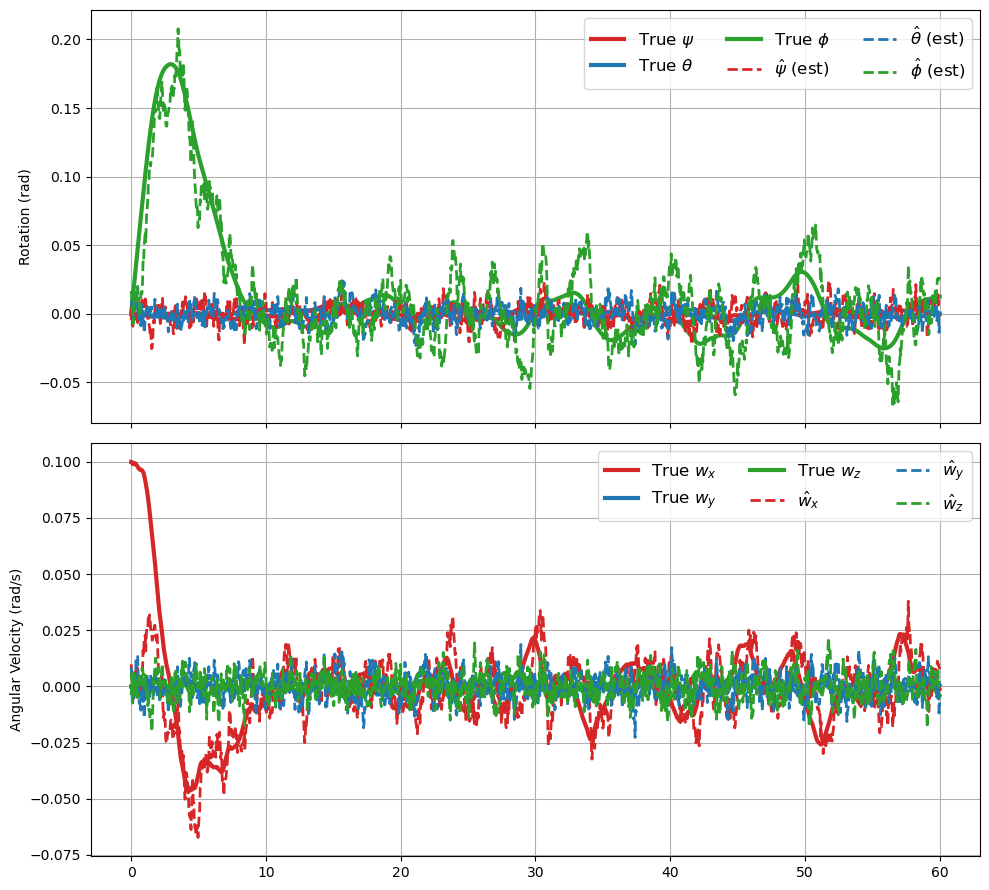

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get logged estimates from the controller
t_est, xhat_log = controller.get_logs()

# Create figure with three subplots
fig, (ax_ori_est, ax_vel_est) = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

# Choose consistent colors for each component
color_psi = 'tab:red'
color_theta = 'tab:blue'
color_phi = 'tab:green'

color_wx = 'tab:red'
color_wy = 'tab:blue'
color_wz = 'tab:green'

# ---- 1. Plot Rotation Estimates vs True Rotation ----
ax_ori_est.plot(data['t'], data['psi'], label=r'True $\psi$', color=color_psi, linewidth=3)
ax_ori_est.plot(data['t'], data['theta'], label=r'True $\theta$', color=color_theta, linewidth=3)
ax_ori_est.plot(data['t'], data['phi'], label=r'True $\phi$', color=color_phi, linewidth=3)

ax_ori_est.plot(t_est, xhat_log[:, 0], '--', label=r'$\hat{\psi}$ (est)', color=color_psi, linewidth=2)
ax_ori_est.plot(t_est, xhat_log[:, 1], '--', label=r'$\hat{\theta}$ (est)', color=color_theta, linewidth=2)
ax_ori_est.plot(t_est, xhat_log[:, 2], '--', label=r'$\hat{\phi}$ (est)', color=color_phi, linewidth=2)

#ax_ori_est.set_ylim(-1, 1)
ax_ori_est.set_ylabel("Rotation (rad)")
ax_ori_est.legend(fontsize=12, ncol=3)
ax_ori_est.grid()

# ---- 2. Plot Angular Velocity Estimates vs True Angular Velocity ----
ax_vel_est.plot(data['t'], data['w_x'], label=r'True $w_x$', color=color_wx, linewidth=3)
ax_vel_est.plot(data['t'], data['w_y'], label=r'True $w_y$', color=color_wy, linewidth=3)
ax_vel_est.plot(data['t'], data['w_z'], label=r'True $w_z$', color=color_wz, linewidth=3)

ax_vel_est.plot(t_est, xhat_log[:, 3], '--', label=r'$\hat{w}_x$', color=color_wx, linewidth=2)
ax_vel_est.plot(t_est, xhat_log[:, 4], '--', label=r'$\hat{w}_y$', color=color_wy, linewidth=2)
ax_vel_est.plot(t_est, xhat_log[:, 5], '--', label=r'$\hat{w}_z$', color=color_wz, linewidth=2)

#ax_vel_est.set_ylim(-1, 1)
ax_vel_est.set_ylabel("Angular Velocity (rad/s)")
ax_vel_est.legend(fontsize=12, ncol=3)
ax_vel_est.grid()

fig.tight_layout()
plt.show()